In [1]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import emd
from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq
from get_signals import get_signals

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

## Анализ основных компонент сигнала (раздел отчета 6.3)
Содержание jupyter notebook (ссылки):
1. [Использование EMD для выделения компонент сигнала](#emd)
2. [Использование Hilbert Transform для определения фазы сигнала](#hilb)
3. [Использование FFT для определения частот основных компонент сигнала](#fft)
4. [Определение типа адаптационной реакции организма](#hist)

**Загрузка данных.**

In [3]:
filename = 'data/hypothenar_data.xlsx'
r_1 = 1.62
r_2 = 2.22
lmbd_1 = 692
lmbd_2 = 834
sto2, d_hb, d_hbo, d_hhb, d_thb, time, d_mua_lmbd1, d_mua_lmbd2 = get_signals(filename, r_1, r_2, lmbd_1, lmbd_2)

In [4]:
df_real = pd.read_excel('data/Diodes1357_HbUa.xlsx')
thb_real = df_real["THC A"].values
hhb_real = df_real[" [De Oxy] A"].values
hbo_real = df_real[" [Oxy] A"].values

<a id='emd'></a>
### Использование EMD для выделения компонент сигнала

**Отрезок сигнала D_Hb c ярко выраженными дыхательными колебаниями**

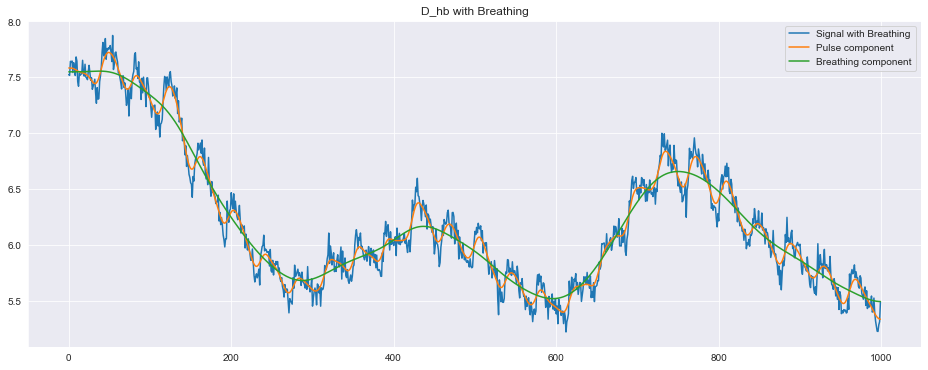

In [5]:
figure, axis = plt.subplots(1, 1, figsize=(16, 6))
plt.plot(d_hb[90*50+1000:90*50+2000])
plt.plot(gaussian_filter1d(d_hb[90*50+1000:90*50+2000], 5))
plt.plot(gaussian_filter1d(d_hb[90*50+1000:90*50+2000], 23))
plt.legend(["Signal with Breathing", "Pulse component", "Breathing component"])
plt.title("D_hb with Breathing")
plt.show()

EMD-разложение сигнала для удаления из него дыхательной компоненты

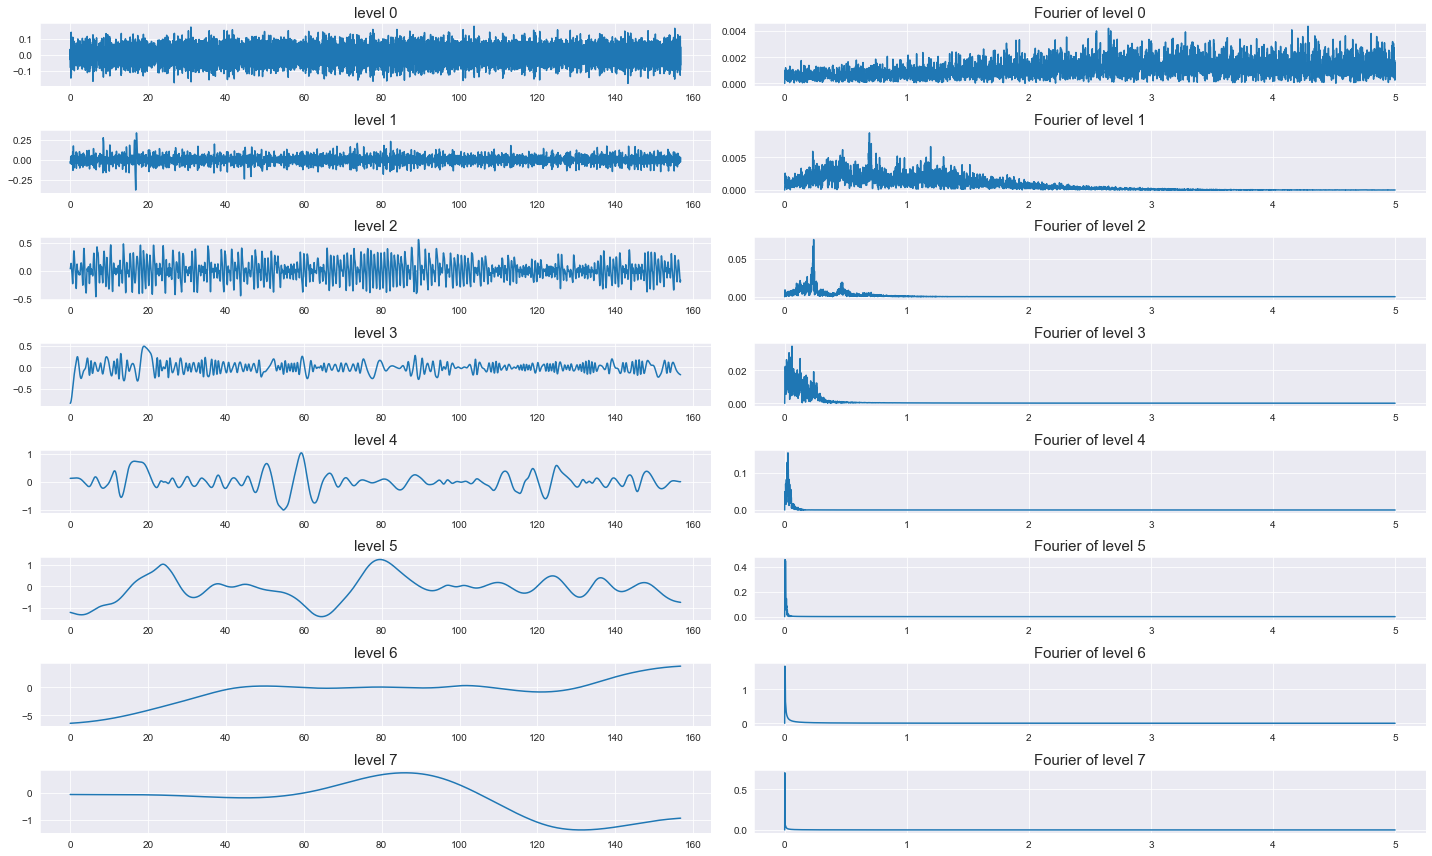

In [6]:
imf = emd.sift.sift(d_hb)
levels = imf.shape[1]
figure, axis = plt.subplots(levels, 2, figsize=(20, 12))
#plt.subplots_adjust(hspace=1.0)
for i in range(levels):
    axis[i][0].set_title('level '+str(i), fontsize=15)
    axis[i][0].plot(time, imf[:, i])

for i in range(levels):
    N = len(imf[:, i])
    spacing = 1 / 10
    fourierTransform = fft(imf[:, i] - np.average(imf[:, i]))
    frequencies = fftfreq(N, spacing)[: N // 2]
    axis[i][1].set_title('Fourier of level '+str(i), fontsize=15)
    axis[i][1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))

plt.tight_layout()
plt.show()

Сигнал до и после удаления дыхательной компоненты, и сама дыхательная компонента

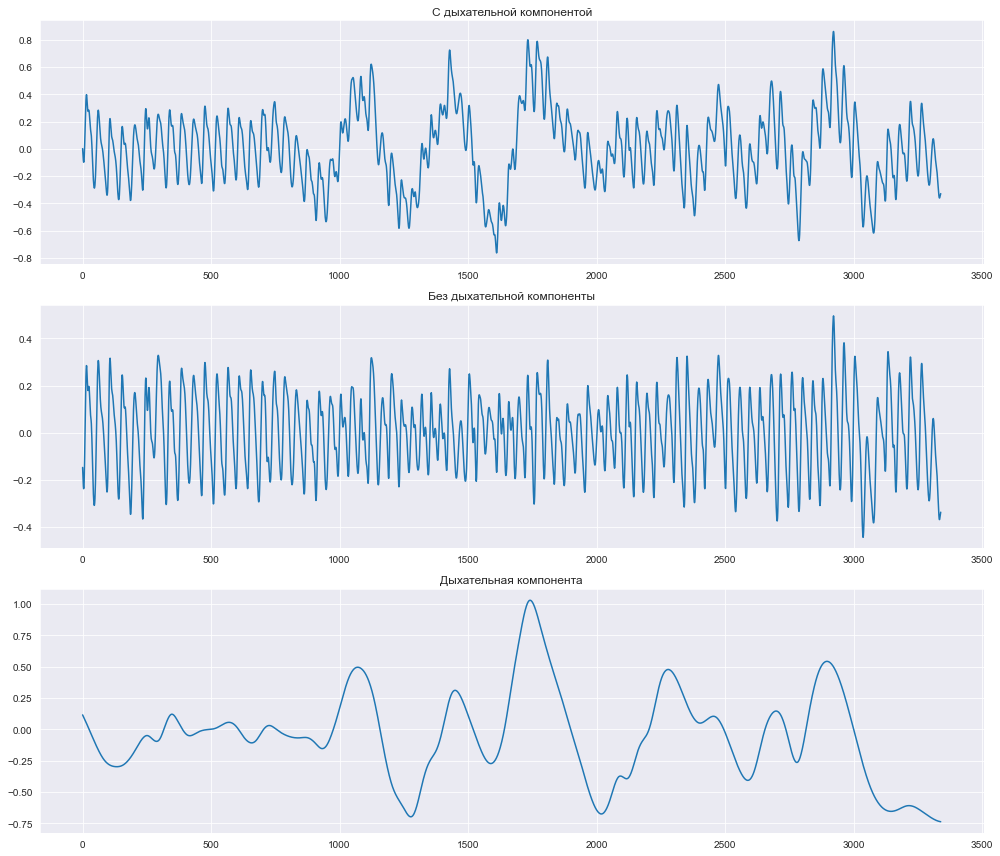

In [7]:
figure, axis = plt.subplots(3, 1, figsize=(14, 12))
axis[0].plot((imf[:, 2]+imf[:, 3]+imf[:, 4])[90*50:300*50])
axis[0].set_title("С дыхательной компонентой")

axis[1].plot((imf[:, 2]+imf[:, 3])[90*50:300*50])
axis[1].set_title("Без дыхательной компоненты")

axis[2].plot((imf[:, 4]+imf[:, 5])[90*50:300*50])
axis[2].set_title("Дыхательная компонента")

plt.tight_layout()
plt.show()

<a id='hilb'></a>
### Использование Hilbert Transform для определения фазы сигнала

In [8]:
from sklearn.preprocessing import StandardScaler

def wrapToPi(x):
    xwrap = np.remainder(x, 2 * np.pi)
    mask = np.abs(xwrap) > np.pi
    xwrap[mask] -= 2 * np.pi * np.sign(xwrap[mask])
    mask1 = x < 0
    mask2 = np.remainder(x, np.pi) == 0
    mask3 = np.remainder(x, 2 * np.pi) != 0
    xwrap[mask1 & mask2 & mask3] -= 2 * np.pi
    return xwrap

На участке сигналов D_Hb и StO2 с выраженной пульсовой компонентой сигналы в основном синфазны

In [9]:
object1 = StandardScaler()
wave1 = object1.fit_transform(gaussian_filter1d(d_hb[90*50:100*50], 3).reshape(-1, 1))

object2 = StandardScaler()
wave2 = object1.fit_transform(gaussian_filter1d(sto2[90*50:100*50], 3).reshape(-1, 1))

wave1 = np.array([i[0] for i in wave1])
wave2 = np.array([i[0] for i in wave2])

hilbert_transformed1 = hilbert(wave1)
hilbert_transformed2 = hilbert(wave2)
phase1 = wrapToPi(np.unwrap(np.angle(hilbert_transformed1)))
phase2 = wrapToPi(np.unwrap(np.angle(hilbert_transformed2)))
differ = wrapToPi(np.abs(phase2 - phase1))

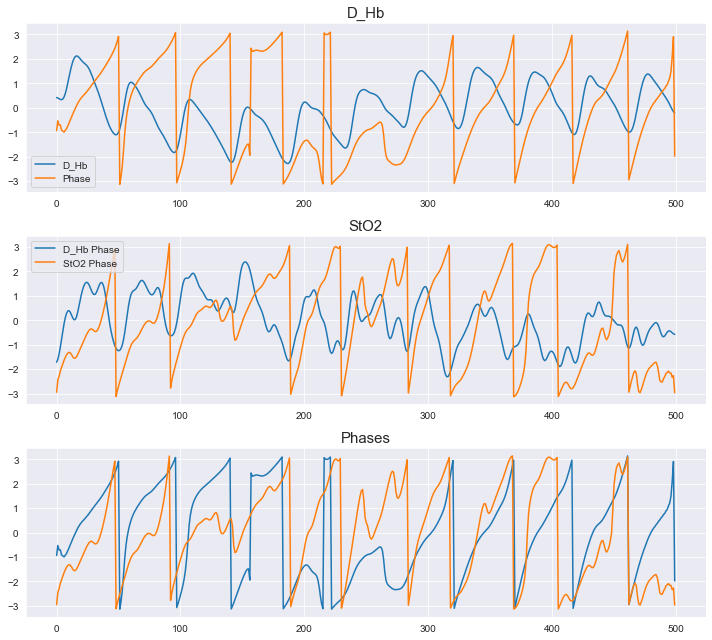

In [10]:
figure, axis = plt.subplots(3, 1, figsize=(10, 9))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('D_Hb', fontsize=15)
axis[0].plot(wave1)
axis[0].plot(phase1)
axis[0].legend(['D_Hb', "Phase"])
axis[1].set_title('StO2', fontsize=15)
axis[1].plot(wave2)
axis[1].plot(phase2)
axis[1].legend(['StO2', "Phase"])
axis[2].set_title('Phases', fontsize=15)
axis[2].plot(phase1)
axis[2].plot(phase2)
axis[1].legend(['D_Hb Phase', "StO2 Phase"])
plt.tight_layout()
plt.show()

На участке сигналов D_Hb и StO2 с выраженной дыхательной компонентой сигналы в основном противофазны

In [11]:
object1 = StandardScaler()
wave1 = object1.fit_transform(gaussian_filter1d(d_hb[90*50+2100:], 12).reshape(-1, 1))

object2 = StandardScaler()
wave2 = object1.fit_transform(gaussian_filter1d(sto2[90*50+2100:], 12).reshape(-1, 1))

wave1 = np.array([i[0] for i in wave1])
wave2 = np.array([i[0] for i in wave2])

hilbert_transformed1 = hilbert(wave1)
hilbert_transformed2 = hilbert(wave2)
phase1 = wrapToPi(np.unwrap(np.angle(hilbert_transformed1)))
phase2 = wrapToPi(np.unwrap(np.angle(hilbert_transformed2)))
differ = wrapToPi(np.abs(phase2 - phase1))

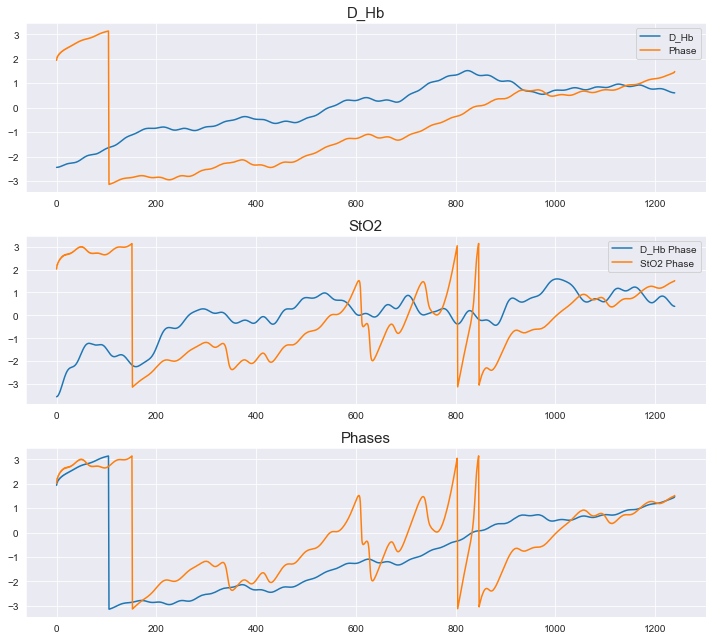

In [12]:
figure, axis = plt.subplots(3, 1, figsize=(10, 9))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('D_Hb', fontsize=15)
axis[0].plot(wave1)
axis[0].plot(phase1)
axis[0].legend(['D_Hb', "Phase"])
axis[1].set_title('StO2', fontsize=15)
axis[1].plot(wave2)
axis[1].plot(phase2)
axis[1].legend(['StO2', "Phase"])
axis[2].set_title('Phases', fontsize=15)
axis[2].plot(phase1)
axis[2].plot(phase2)
axis[1].legend(['D_Hb Phase', "StO2 Phase"])
plt.tight_layout()
plt.show()

**Загрузка другого набора данных, полученных во время физической нагрузки**

In [13]:
data = np.genfromtxt('data/MAN_Hb_10Hz.txt', delimiter='\t')
data_t = np.transpose(data)
idxs = []
for i in range(1, len(data_t[1])):
    if data_t[1][i] - data_t[1][i-1] > 0.85:
        idxs.append(i)
markers = np.array(idxs)
reference_between_markers = ["test", "baseline", "step1", "10s_rest", "step2", "10s_rest", "step3", \
                        "10s_rest", "step4", "10s_rest", "step5", "1m_rest", "3m_rest", "5m_rest", "8m_rest"]
column_names = ["time", "aux", "stoA", "thbA", "hboA", "hhbA", "stoB", "thbB", "hboB", "hhbB"]
borders = dict()
for i in range(len(reference_between_markers)):
    borders[reference_between_markers[i]] = (markers[i], markers[i+1])
name_to_col = dict()
for i in range(len(column_names)):
    name_to_col[column_names[i]] = i
column_pairs = dict()
for i in ["sto", "thb", "hbo", "hhb"]:
    column_pairs[i] = (name_to_col[i+"A"], name_to_col[i+"B"])

Для определенных пар сигналов известно, что они должны быть синфазны или, наоборот, противофазны. Изменение предполагаемой разности фаз таких сигналов свидетельствует о проблемах, возникших в регуляции организма.
Пример противофазных сигналов

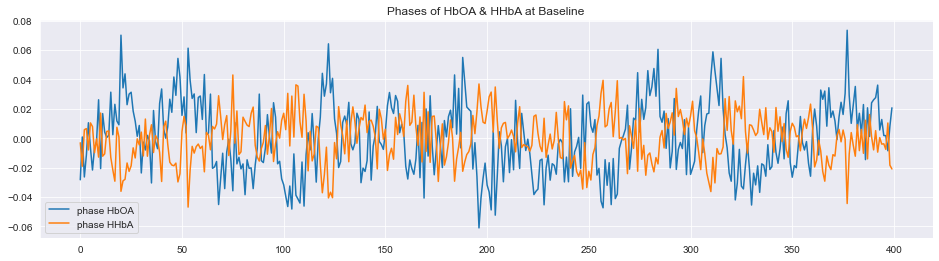

In [14]:
start4, end4 = (2300, 2700)
wave1 = data_t[name_to_col["hboA"]][start4:end4]
wave2 = data_t[name_to_col["hhbA"]][start4:end4]


hilbert_transformed1 = hilbert(wave1)
hilbert_transformed2 = hilbert(wave2)
phase1 = np.angle(hilbert_transformed1)
phase2 = np.angle(hilbert_transformed2)
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(phase1)
plt.plot(phase2)
plt.legend(["phase HbOA", "phase HHbA"])
plt.title("Phases of HbOA & HHbA at Baseline")
plt.show()

<a id='fft'></a>
### Использование преобразования Фурье для определения частот основных компонент сигнала

Дыхательная и пульсовая компоненты четко отображаются на графике преобразования Фурье в виде пиков. Например, на приведенном графике сигнала с работающей мышцы ноги выделяются следующие частотные компоненты: пик с частотой ~0.4 Гц - дыхательная компонента, пик с частотой ~1.6 Гц - пульсовая компонента, пик с частотой ~0.8 Гц - это частота шага, и медленные колебания с частотами меньше 0.4.

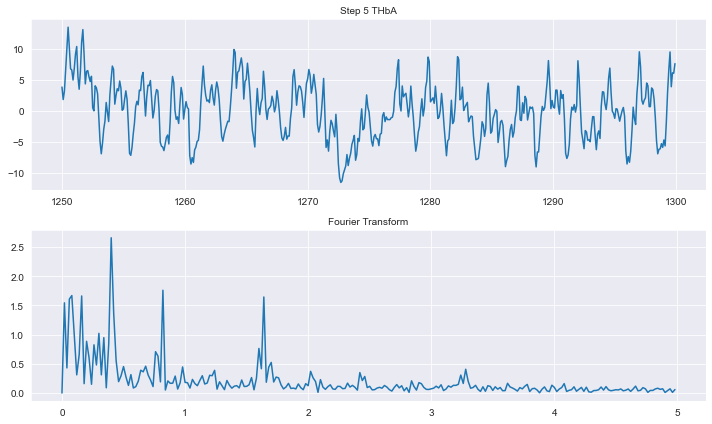

In [15]:
era = "step5"
column = "thb"
start, end = (12500, 13000)
cA, cB = column_pairs[column]
thbA_5 = data_t[cA][start:end]
thbB_5 = data_t[cB][start:end]
time = data_t[name_to_col["time"]][start:end]

N = len(thbA_5)
spacing = 1 / 10
fourierTransform = fft(thbA_5 - np.average(thbA_5))
frequencies = fftfreq(N, spacing)[: N // 2]

figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Step 5 THbA', fontsize=10)
axis[0].plot(time, thbA_5 - np.average(thbA_5))
axis[1].set_title('Fourier Transform', fontsize=10)
axis[1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))
plt.tight_layout()
plt.show()

<a id='hist'></a>
### Определение типа адаптационной реакции организма

Для определения состояния организма информативной является гистограмма, на которой изображены доли каждой компоненты в общем сигнале (эндогенная компонента не присутствует, т.к. она слишком медленная и сливается с трендом). Доли каждой компоненты определяются по соответствующим ей амплитудам на графике преобразования Фурье. Пример гистограмм для во время ходьбы и при восстановлении приведен ниже

In [16]:
endo = [0.095, 0.02]
neo = [0.021, 0.046]
mio = [0.047, 0.145]
breath = [0.2, 0.4]
heart = [0.8, 1.6]

In [17]:
era1 = "baseline"
era2 = "step5"
era3 = ('5m_rest', '8m_rest')
column = "thb"
start1, end1 = borders[era1]
start2, end2 = borders[era2]
start3, end3 = (borders[era3[0]][0], borders[era3[1]][1])
cA, cB = column_pairs[column]

new_A = data_t[cA].copy() - emd.sift.sift(data_t[cA].copy())[:, 0]
new_A -= np.average(new_A)
new_B = data_t[cB].copy() - emd.sift.sift(data_t[cB].copy())[:, 0]
new_B -= np.average(new_B)
thbA1_5 = new_A[start1:end1].copy()
thbB1_5 = new_B[start1:end1].copy()
thbA2_5 = new_A[start2:end2].copy()
thbB2_5 = new_B[start2:end2].copy()
thbA3_5 = new_B[start3:end3].copy()
thbB3_5 = data_t[cB][start3:end3].copy()
time1 = data_t[name_to_col["time"]][start1:end1].copy()
time2 = data_t[name_to_col["time"]][start2:end2].copy()
time3 = data_t[name_to_col["time"]][start3:end3].copy()

In [18]:
era4 = ('1m_rest', '3m_rest')
start4, end4 = (borders[era4[0]][0], borders[era4[1]][1])
thbB4_5 = data_t[cB][start4:end4].copy()

In [19]:
def get_values(signal):
    N = len(signal)
    spacing = 1 / 10
    fourierTransform = fft(signal.copy())
    frequencies = fftfreq(N, spacing)[: N // 2]
    values =  2.0 / N * np.abs(fourierTransform[0 : N // 2])

    e_v = 0
    n_v = 0
    m_v = 0
    b_v = 0
    h_v = 0
    total = 0
    numbers = [0 for i in range(5)]
    for i in range(len(frequencies)):
        if frequencies[i] >= endo[0] and frequencies[i] <= endo[1]:
            e_v += values[i]
            total += values[i]
            numbers[0] += 1
        elif frequencies[i] >= neo[0] and frequencies[i] <= neo[1]:
            n_v += values[i]
            total += values[i]
            numbers[1] += 1
        elif frequencies[i] >= mio[0] and frequencies[i] <= mio[1]:
            m_v += values[i]
            total += values[i]
            numbers[2] += 1
        elif frequencies[i] >= breath[0] and frequencies[i] <= breath[1]:
            b_v += values[i]
            total += values[i]
            numbers[3] += 1
        elif frequencies[i] >= heart[0] and frequencies[i] <= heart[1]:
            h_v += values[i]
            total += values[i]
            numbers[4] += 1
    res = np.array([n_v/total, m_v/total, b_v/total, h_v/total, 0])
    numbers.append(1)
    res /= np.array(numbers[1:])
    res *= (sum(numbers) - 1)
    res[-1] = (res[-2] + res[-3]) / (res[0] + res[1])
    return res

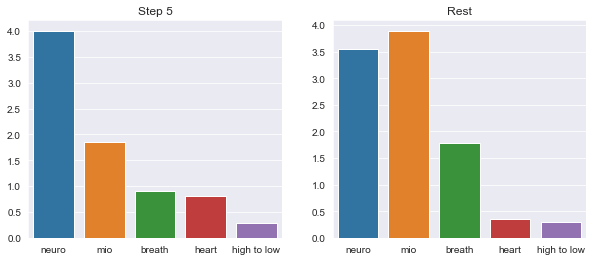

In [20]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
res_1 = get_values(thbB2_5)
res_2 = get_values(thbB4_5)
types = ["neuro", "mio", "breath", "heart", "high to low"]
sns.barplot(x=types, y=res_1, ax=ax1).set_title('Step 5')
sns.barplot(x=types, y=res_2, ax=ax2).set_title('Rest')
plt.show()